# 2 &emsp; Building and using matrices

This notebook is copied from tngTUDOR [from-the-ground-up notebook](http://localhost:8889/lab/tree/2%20-%20Building%20and%20using%20matrices%20in%20bw2calc.ipynb) series. With additional personal notes.

### Import necessary packages

One difference between Brightway 2 (BW2) and Brightway 2.5 (BW25) is that, unlike BW2, `from brightway2 import *` does not work, therefore it won't import all the needed packages such as `bwcalc`, `bwio`, etc. In BW25 we need to import all the packages we might need individually.

In [45]:
import bw_processing as bwp
import matrix_utils as mu
import bw2calc as bc
import numpy as np
import seaborn as sb
import pandas as pd

Before we dive into it, let's think about what we need to actually build in a matrix. What specific data would you need? What don't you need?

### Exercise

Please think about the minimal set of information you would need to build a *sparse matrix* using [scipy.sparse.coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) (sparse matrices store only non-zero values). Then, create this information as Numpy arrays and actually build a sparse matrix.

Here is the matrix you should build:

$$\begin{bmatrix} 0 & 1 \\ 2 & 3 \end{bmatrix}$$

##### Hint
You need three Numpy arrays: one for the data, one for the row indices and one for the column indices.

In [46]:
from scipy import sparse

data = np.array([1, 2, 3])
rows = np.array([0, 1, 1])
cols = np.array([1, 0, 1])
matrix = sparse.coo_matrix((data, (rows, cols)), (2, 2)) 
print(matrix)
matrix.toarray()

  (0, 1)	1
  (1, 0)	2
  (1, 1)	3


array([[0, 1],
       [2, 3]])

Ring a bell? This is more or less what happens with the technology matrix!!, what we are doing, is making the matrix square and filling with zeroes the empty spaces (REALLY SIMPLISTIC DESCRIPTION OF WHAT IS GOING ON!).

## `bw_processing`

We can run into difficulties when we want to store this data. The library `bw_processing` helps us create data packages, which can store this matrix-building data on variety of file systems. You can read the [`bw_processing` README](https://github.com/brightway-lca/bw_processing) for more information, and can see the [PyFilesystem2 Docs](https://docs.pyfilesystem.org/en/latest/) for more on the filesystems that can be used.

Let's define this same matrix in `bw_processing`.

Matrices by definition are two-dimensional, so we know that to build matrices we will always need to specify the row and column indices of the data. We combine these two arrays into a single Numpy [structured array](https://numpy.org/doc/stable/user/basics.rec.html), which uses the labels `row` and `col`.

In [47]:
import bw_processing as bwp
import numpy as np

indices_array = np.array([(0, 1), (1, 0), (1, 1)], dtype=bwp.INDICES_DTYPE)
indices_array

array([(0, 1), (1, 0), (1, 1)], dtype=[('row', '<i4'), ('col', '<i4')])

In [48]:
print('ROW ', indices_array['row'])
print('COL ', indices_array['col'])

ROW  [0 1 1]
COL  [1 0 1]


In [49]:
bwp.INDICES_DTYPE

[('row', numpy.int32), ('col', numpy.int32)]

The data array is the same as before:

In [50]:
data_array = np.array([1, 2, 3])
data_array

array([1, 2, 3])

In [51]:
dp = bwp.create_datapackage()

dp.add_persistent_vector(
    matrix="some matrix name",
    data_array=data_array,
    name="some name",
    indices_array=indices_array,
)

But before this gets too abstract, let's do the same for our example system:

![PROJECT:](images/simple-graph.png)

In our technosphere matrix, we will have three production exchanges (each of amount 1), and two consumption exchanges. Our biosphere matrix will only have one number, the emission of CO<sub>2</sub> from carbon fibre production.

Our matrices should look like this:
#### Technosphere matrix

Dimensions are exchanges/edges (rows) by activities/productions/nodes (columns). 

$$
\left[\begin{array}{ccc} 
1 & 0 & 0\\
-237 & 1 & 0\\
0 & -2.5 & 1\\
\end{array}\right]
$$

I think the matrix is wrong and should be:

$$
\left[\begin{array}{ccc} 
1 & -237 & 0\\
0 & 1 & -2.5\\
0 & 0 & 1\\
\end{array}\right]
$$

#### Biosphere matrix

Dimensions are exchanges/edges (rows) by activities/productions/nodes (columns).

$$
\left[\begin{array}{ccc} 
0 & 26.6 & 0\\ 
\end{array}\right]
$$ 

#### Characterization matrix

Dimensions are flows (rows) by flows (columns).

$$
\left[\begin{array}{c} 
1\\ 
\end{array}\right]
$$

### LCA calculation

To use datapackages, we need to know four things for each point: 
1. Row IDs
2. Column IDs.
3. Data value.
4. The sign. 

We only need to store the non-zero points. Here is an example for the technosphere matrix:

Let's put some codes to our products:

In [52]:
natural_gas = 101 
carbon_fibre = 102
bike = 103
co2 = 201

#### Technosphere matrix data.

In [53]:
t_data = np.array([1, 1, 1, 237, 2.5])
t_indices = np.array([
    (101, 101), # production of natural gas
    (102, 102), # production of carbon fibre
    (103, 103), # production of bike
    (101, 102), # input of natural gas
    (102, 103), # input of carbon fibre
    ], 
    dtype=bwp.INDICES_DTYPE
)
t_flip = np.array([False, False, False, True, True]) # Numerical sign of the inputs needs to be flipped negative

And similarly for the other matrices (no need to flip signs, so we skip that part):

#### Biosphere matrox data

In [54]:
b_data = np.array([26.6])
b_indices = np.array([
    (201, 102), # emission of CO2
    ], 
    dtype=bwp.INDICES_DTYPE
)

#### Characterization matrix

In [55]:
c_data = np.array([1])
c_indices = np.array([
    (201, 201), # CF of CO2
    ], 
    dtype=bwp.INDICES_DTYPE
)

We can now create our datapackage, and add the data for all three matrices to it:

In [56]:
dp_static = bwp.create_datapackage()

In [57]:
dp_static.add_persistent_vector(
    matrix='technosphere_matrix',
    indices_array=t_indices,
    data_array=t_data,
    flip_array=t_flip,
)
dp_static.add_persistent_vector(
    matrix='biosphere_matrix',
    indices_array=b_indices,
    data_array=b_data,
)
dp_static.add_persistent_vector(
    matrix='characterization_matrix',
    indices_array=c_indices,
    data_array=c_data,
)

This is already enough to calculate an LCA score:

In [58]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_static],
)
lca.lci()
lca.lcia()
lca.score

66.50000000000001

Same as before! Weee!

### A stochastic LCA

This is pretty boring so far. The only marginally interesting thing is that we could put our datapackage on another computer, and do calculations on that computer - i.e. we are ready for cloud calculations. Indeed, the library `matrix_utils` allows us to specify datapackages on FTP sites and cloud storage such as Amazon S3.

But we can make our example more interesting by adding uncertainty. To do this, we will use the standards in the [stats_arrays](https://stats-arrays.readthedocs.io/en/latest/) library.

We will only add uncertainty to the inputs (check [here](https://2.docs.brightway.dev/intro.html#storing-uncertain-values) for further information about uncertainty and types, for example Weibull uncertainty is 8!), and the CO2 emission. The other edges will have uncertainty type zero - no uncertainty.

In [59]:
t_uncertainty = np.array([
        (0, 1, np.NaN, np.NaN, np.NaN, np.NaN, False),
        (0, 1, np.NaN, np.NaN, np.NaN, np.NaN, False),    
        (0, 1, np.NaN, np.NaN, np.NaN, np.NaN, False),    
        (5, 237, np.NaN, np.NaN, 200, 300, False), # triangular uncertainty from 200 to 300  
        (5, 2.5, np.NaN, np.NaN, 2, 3, False), # triangular uncertainty from 2 to 3
    ], 
    dtype=bwp.UNCERTAINTY_DTYPE
)
b_uncertainty = np.array([
        (3, 26.6, 1.5, np.NaN, np.NaN, np.NaN, False), # normal uncertainty with std. dev. of 1.5
    ], 
    dtype=bwp.UNCERTAINTY_DTYPE
)

In [60]:
print(bwp.UNCERTAINTY_DTYPE )

[('uncertainty_type', <class 'numpy.uint8'>), ('loc', <class 'numpy.float32'>), ('scale', <class 'numpy.float32'>), ('shape', <class 'numpy.float32'>), ('minimum', <class 'numpy.float32'>), ('maximum', <class 'numpy.float32'>), ('negative', <class 'bool'>)]


We then will create another data package, and use it to do Monte Carlo:

In [61]:
dp_stochastic = bwp.create_datapackage()

In [62]:
dp_stochastic.add_persistent_vector(
    matrix='technosphere_matrix',
    indices_array=t_indices,
    data_array=t_data,
    flip_array=t_flip,
    distributions_array=t_uncertainty,
)
dp_stochastic.add_persistent_vector(
    matrix='biosphere_matrix',
    indices_array=b_indices,
    data_array=b_data,
    distributions_array=b_uncertainty,
)
dp_stochastic.add_persistent_vector(
    matrix='characterization_matrix',
    indices_array=c_indices,
    data_array=c_data,
)

In [63]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_stochastic],
    use_distributions=True,
)
lca.lci()
lca.lcia()
    
mc_results_100 = np.array([lca.score for _ in zip(range(100), lca)])
mc_results_1000 = np.array([lca.score for _ in zip(range(1000), lca)])
mc_results_10000 = np.array([lca.score for _ in zip(range(10000), lca)])

The original tutorial just plotted a Monte Carlo of 100 iterations, here I am comparing three. First I make a dataframe and then I plot it with seaborn.

In [64]:
df = pd.DataFrame({'MC 100': pd.Series(mc_results_100),'MC 1000': pd.Series(mc_results_1000),'MC 10000': pd.Series(mc_results_10000)})

In [65]:
dfm = df.melt(var_name='Simulation', value_name='Score')

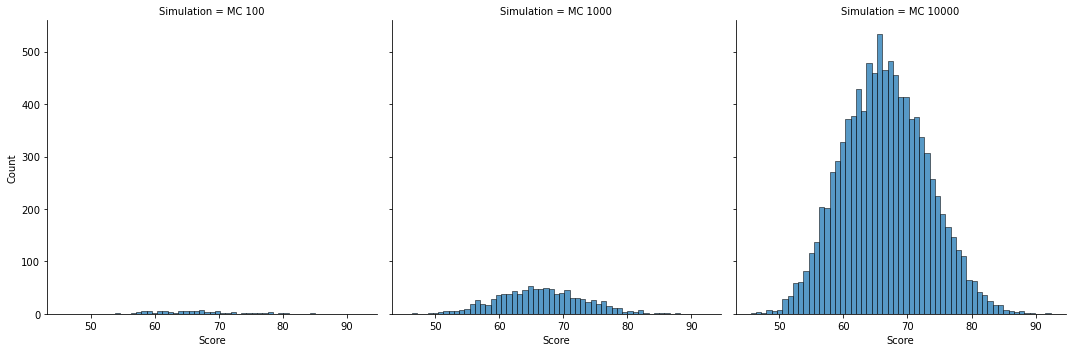

In [66]:
sb.displot(dfm, x='Score', col="Simulation")

In [67]:
mc_results_100.mean(), mc_results_1000.mean(), mc_results_10000.mean()

(66.11133576913376, 66.45187906257902, 66.48112993285093)

### Correlating exchanges

If we sample each exchange independently, we lose some of the logic of our product system. In our example system, the CO<sub>2</sub> should be tied directly to the natural gas consumption, but it isn't:

In [68]:
params = []

for _ in range(100):
    next(lca)
    params.append({
        'co2': lca.biosphere_matrix[lca.dicts.biosphere[co2], lca.dicts.activity[carbon_fibre]],
        'ng': -1 * lca.technosphere_matrix[lca.dicts.product[natural_gas], lca.dicts.activity[carbon_fibre]],
    })

<AxesSubplot:xlabel='ng', ylabel='co2'>

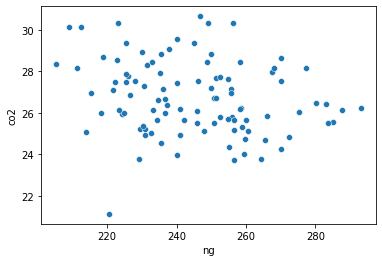

In [69]:
sb.scatterplot(data=pd.DataFrame(params), x='ng', y='co2')

We fix this by drawing correlated samples ahead of time - this is the idea behind the `presamples` package, whose functionality is now integrated directly into Brightway. We will make up a model to illustrate how this would work; we can assume that (again, totally made up) 80% of the natural gas goes to energy, the ratio stays the same, but with a little bit of noise.

In [70]:
ng_samples = np.random.triangular(200, 237, 300, size=100)
co2_samples = 26.6 / 237 * ng_samples * np.random.normal(loc=1, scale=0.025, size=100)

We can now add another datapackage which will overwrite our previous values (but only where we tell it to). Note that we are now creating `arrays`, not `vectors`.

We need to tell the datapackage that these two resources are correlated - otherwise there would be two RNGs used to samples them independently again. We can do this by either setting `sequential=True` (in which case they would start with column 0, then column 1, etc.), or by using the same RNG seed for both resources.

In [71]:
dp_correlated = bwp.create_datapackage(seed=42)

In [72]:
dp_correlated.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=np.array([(101, 102)], dtype=bwp.INDICES_DTYPE),
    data_array=ng_samples.reshape((1, -1)),
    flip_array=np.array([True]) ,
)
dp_correlated.add_persistent_array(
    matrix='biosphere_matrix',
    indices_array=np.array([(201, 102)], dtype=bwp.INDICES_DTYPE),
    data_array=co2_samples.reshape((1, -1)),
)

And now the use of our correlated samples reflects reality a lot better. Note that we just add the new datapackage after the original one, and set `use_arrays=True`:

In [73]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_stochastic, dp_correlated],
    use_distributions=True,
    use_arrays=True,
)
lca.lci()
lca.lcia()

corr_params = []

for _ in range(100):
    next(lca)
    corr_params.append({
        'co2': lca.biosphere_matrix[lca.dicts.biosphere[co2], lca.dicts.activity[carbon_fibre]],
        'ng': -1 * lca.technosphere_matrix[lca.dicts.product[natural_gas], lca.dicts.activity[carbon_fibre]],
    })

<AxesSubplot:xlabel='ng', ylabel='co2'>

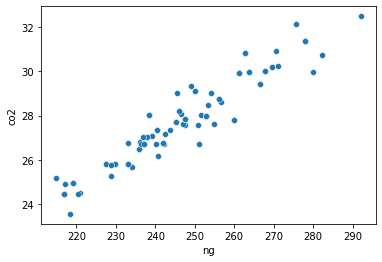

In [74]:
sb.scatterplot(data=pd.DataFrame(corr_params), x='ng', y='co2')

### Using arrays for scenarios



In addition to correlated samples, we can use arrays for scenarios. Let's imagine two different possibilities: a lightweight bike with 1.5 kilograms of carbon fibre, and a technology platform that allows for efficient bike sharing making each bike functionally equivalent to two bikes (I know, I find this silly as well). If we treat these as separate possibilities, we have four scenarios in total.

For this to work, we will need to create **two** new arrays, one for each choice, and then tell the software to do combinatorial sampling:

In [75]:
dp_scenarios = bwp.create_datapackage(combinatorial=True)

In [76]:
dp_scenarios.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=np.array([(102, 103)], dtype=bwp.INDICES_DTYPE),
    data_array=np.array([(2.5, 1.5)]),
    flip_array=np.array([True]),
    name='cf scenario'
)
dp_scenarios.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=np.array([(103, 103)], dtype=bwp.INDICES_DTYPE),
    data_array=np.array([(1, 2)]),
    name='double bike'
)

In [77]:
scenario_mapping = {
    (0, 0): "Original",
    (0, 1): "Each bike counts double",
    (1, 0): "Lightweight",
    (1, 1): "Lightweight & each bike counts double",
}

In [78]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_static, dp_scenarios],
    use_arrays=True,
)
lca.lci()
lca.lcia()

In [79]:
resource_group = next(grp for grp in lca.technosphere_mm.groups if grp.label == 'double bike').indexer.indexer

In [80]:
print(lca.score, scenario_mapping[resource_group.index])

for scenario_result in lca:
    print(lca.score, scenario_mapping[resource_group.index])

66.50000000000001 Original
33.25000000000001 Each bike counts double
39.900000000000006 Lightweight
19.950000000000003 Lightweight & each bike counts double


### Interfaces

We can add some electricity consumption to the bike manufacturing process, and demonstrate how an `Interface` should work. For our example interface, we can use the Danish company Energinet's [API for the 5 minute interval CO2 intensity of Danish electricity](https://www.energidataservice.dk/tso-electricity/co2emis):

In [86]:
import requests
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

class DenmarkCO2Interface:
    size = (1,)

    def __next__(self):
        URL = 'https://api.energidataservice.dk/datastore_search?resource_id=co2emis&limit=1&sort=Minutes5UTC%20desc'
        print("Querying energidataservice.dk API")
        result = requests.get(URL, verify=False).json()['result']['records'][0]['CO2Emission']
        return np.array([result]) / 1000 # g to kg
    
    


That was just the CO<sub>2</sub> intensity, we also need to add a node for electricity consumption. We will give it the ID `104`, and use 100 kilowatt hours (way too high, I know).

In [87]:
dk_elec_dp = bwp.create_datapackage()

In [88]:
dk_elec_dp.add_persistent_vector(
    matrix='technosphere_matrix',
    indices_array=np.array([
            (104, 104), # production of electricity
            (104, 103), # use of electricity in bike production
        ], 
        dtype=bwp.INDICES_DTYPE
    ),
    data_array=np.array([1, 100]),
    flip_array=np.array([False, True]),
)

We can now add our interface. We are not adding `persistent` data, but `dynamic` data:

In [89]:
dk_elec_dp.add_dynamic_vector(
    matrix='biosphere_matrix',
    interface=DenmarkCO2Interface(),
    indices_array=np.array([(201, 104)], dtype=bwp.INDICES_DTYPE),
)



As before, we can just add the data packages together:

In [90]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_static, dk_elec_dp],
)
lca.lci()
lca.lcia()
lca.score

Querying energidataservice.dk API


/Users/mmendez/miniconda3/envs/bw25_rosetta/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.energidataservice.dk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


75.90000000000002

This is the value we got for CO2 intensity (in kg CO2-eq/kwh):

In [91]:
lca.biosphere_matrix[0, lca.dicts.activity[104]]

0.094

Other countries also have similar APIs, for example France:

In [94]:
from time import time
import xml.etree.ElementTree as ET

class FranceCO2Interface:
    size = (1,)
    
    def __next__(self):
        # Note: has timestamp but seems to always give latest data
        URL_TEMPLATE = "https://www.rte-france.com/themes/swi/xml/power-co2-emission-fr.xml?_={}"
        print("Querying RTE Eco2mix interface")
        URL = URL_TEMPLATE.format(int(time()))
        resp = requests.get(URL, verify=False)
        root = ET.fromstring(resp.text)
        return np.array([[float(child.text) for child in root.iter('valeur')][-1]]) / 1000 # g to kg

In [95]:
fr_elec_dp = bwp.create_datapackage()

fr_elec_dp.add_persistent_vector(
    matrix='technosphere_matrix',
    indices_array=np.array([
            (104, 104), # production of electricity
            (104, 103), # use of electricity in bike production
        ], 
        dtype=bwp.INDICES_DTYPE
    ),
    data_array=np.array([1, 100]),
    flip_array=np.array([False, True]),
)

fr_elec_dp.add_dynamic_vector(
    matrix='biosphere_matrix',
    interface=FranceCO2Interface(),
    indices_array=np.array([(201, 104)], dtype=bwp.INDICES_DTYPE),
)

As before, we can just add the data packages together:

In [96]:
lca = bc.LCA(
    demand={bike: 1},
    data_objs=[dp_static, fr_elec_dp],
)
lca.lci()
lca.lcia()
lca.score

Querying RTE Eco2mix interface


/Users/mmendez/miniconda3/envs/bw25_rosetta/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.rte-france.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


71.40000000000002

This is the value we got for CO2 intensity (in kg CO2-eq/kwh):

In [97]:
lca.biosphere_matrix[0, lca.dicts.activity[104]]

0.049